In [2]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
import scipy
import matplotlib.pyplot as plt
from survival_analysis import setup, ats_fit, kaplan_meier

Error importing in API mode: ImportError("dlopen(/opt/anaconda3/lib/python3.12/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <05EE76C0-33BF-3D4C-BC56-84005241BC88> /opt/anaconda3/lib/python3.12/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


In [3]:
hdul = fits.open("Data/HI-withMA-withPIPE3D.fits")
dataTable = Table(hdul[1].data)
dataTable # to see if it worked, we will print out the table

plateifu,ang_stellar,ang_ha,OBJRA_1,OBJDEC_1,LOGMSTARS,VOPT,RMS,LOGHILIM200KMS,SNR,FHI,LOGMHI,log_SFR_Ha,log_Mass,log_SFR_ssp
str12,float32,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64
8622-3703,199.0,18.5,351.2254638671875,14.216151237487793,9.574823379516602,7681.337,2.2,-999.0,7.0,1.1,9.45,-0.76266069438179,10.1095346278908,-0.0297115349713745
8952-3704,294.5,254.0,206.08572387695312,26.084192276000977,10.065818786621094,8474.986,2.1179023,9.313545,-999.0,-999.0,-999.0,-1.88390897415109,10.6245767970672,-1.12904874352718
8093-6103,307.5,56.5,19.590383529663086,15.409425735473633,10.558267593383789,11290.798,2.6958663,9.665635,-999.0,-999.0,-999.0,-1.22231648781419,11.0523757749862,-1.09591408005801
11021-3702,109.0,11.5,198.170838903,53.7147359215,10.069888406629797,7179.6,1.6034691,8.895555,-999.0,-999.0,-999.0,-1.41459435719359,10.6782050812892,-1.23823666873358
10500-12703,213.5,318.5,137.160232544,32.5929527283,10.111501108387221,4265.7,1.6677163,8.462318,-999.0,-999.0,-999.0,-0.418348998668357,10.7006634820747,-1.02629012184449
9866-3701,30.0,207.0,243.0633087158203,31.818723678588867,10.143058776855469,14803.465,2.9166586,9.932747,-999.0,-999.0,-999.0,-0.475604102126105,10.6479522461653,-0.747342993616185
8446-1902,60.0,249.5,206.154337129,37.1716322286,10.182503100253506,7976.7,1.5506914,-999.0,7.386829,2.6994867,9.916596,-1.03910783643127,10.6203606121023,-1.56422083455269
8077-3704,24.5,203.0,42.1984450083,-0.10918489701,10.024859049659549,7396.6,1.590993,8.917882,-999.0,-999.0,-999.0,-0.532436446086757,10.3649669290159,-0.323395010622631
8077-3704,24.5,203.0,42.19844436645508,-0.10918489843606949,10.024859428405762,7396.7554,2.9233203,9.336035,-999.0,-999.0,-999.0,-0.532436446086757,10.3649669290159,-0.323395010622631


In [4]:
'''
Let's get a list of all of the columns, since it may be hard to refer to them just from looking at the cell output:
'''
columnNames = []
for column in dataTable.columns:
    columnNames.append(column)
print(columnNames)

['plateifu', 'ang_stellar', 'ang_ha', 'OBJRA_1', 'OBJDEC_1', 'LOGMSTARS', 'VOPT', 'RMS', 'LOGHILIM200KMS', 'SNR', 'FHI', 'LOGMHI', 'log_SFR_Ha', 'log_Mass', 'log_SFR_ssp']


Let's first visualize the data by plotting all galaxies' positions, just to make sure everything is going smoothly so far. As we saw above, there are 6938 galaxies in the file now, though not all of them have data for all of their parameters.

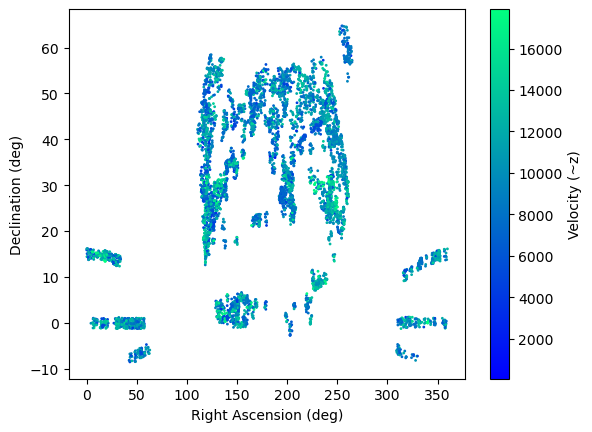

In [5]:
plot = plt.scatter(dataTable['OBJRA_1'], dataTable['OBJDEC_1'], c = dataTable['VOPT'], cmap = 'winter', s=1)
plt.colorbar(plot, label = 'Velocity (~z)')
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.show()

Now we can start looking at the relevant data; the position angles of the gas and stellar disks, and the HI deficiencies of the galaxies. First, lets just plot the galaxies' masses of gas as a function of stellar mass.

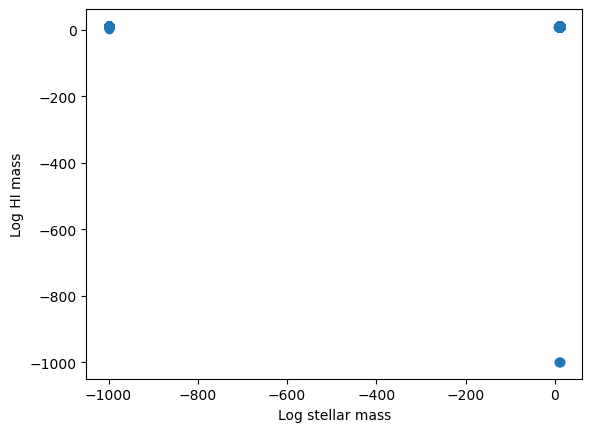

In [6]:
plt.scatter(dataTable['LOGMHI'], dataTable['LOGMSTARS'])
plt.xlabel('Log stellar mass')
plt.ylabel('Log HI mass');

Hmm... it looks like we have outliers. Non-detections are recorded as having values of -999, so we need to make sure we select the right data points. Let's make arrays that select for the useful data.

In [7]:
allGalStellarMass = []
allGalGasMass = []
for gal in dataTable:
    if gal['LOGMSTARS'] > 0 and max(gal['LOGMHI'], gal['LOGHILIM200KMS']) > 0:
        allGalStellarMass.append(gal['LOGMSTARS'])
        allGalGasMass.append(max(gal['LOGMHI'], gal['LOGHILIM200KMS']))

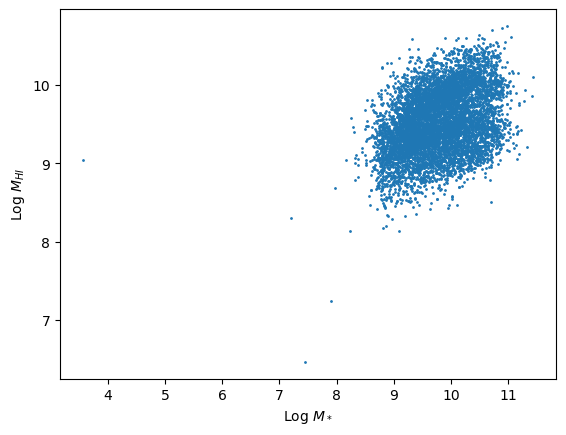

In [8]:
plt.scatter(allGalStellarMass, allGalGasMass, s=1)
plt.xlabel('Log $M_*$')
plt.ylabel('Log $M_{HI}$');

Good! We've removed our non-detection outliers (though we've just assumed that our non-detection upper limits for HI mass are true values, which isn't quite right. We'll have to account for that later with statistical methods, i.e. survival analysis). Now, let's revise this data to represent mass fraction, the log of the ratio of gas mass to stellar mass

In [9]:
allGalMassFraction = [0]*len(allGalStellarMass)
for i in range(len(allGalStellarMass)):
    allGalMassFraction[i] = allGalGasMass[i] - allGalStellarMass[i]

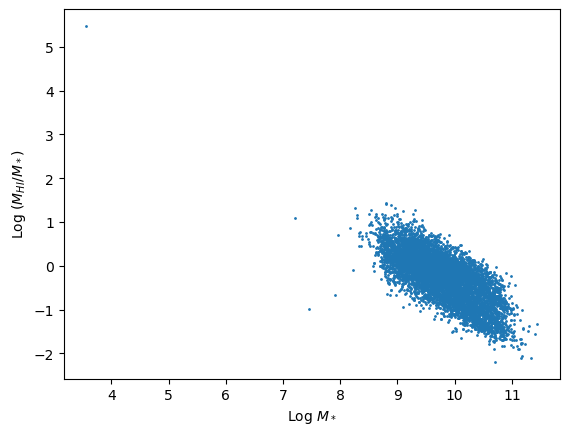

In [10]:
plt.xlabel('Log $M_*$')
plt.ylabel('Log $(M_{HI}/M_*)$')
plt.scatter(allGalStellarMass, allGalMassFraction, s=1);

We'll also change the bounds of the plot to exclude the one point far from the rest of the data (in the top left corner), which will allow us to improve the readability of the plot without skewing the data (though we should keep in mind that some data is not being shown).

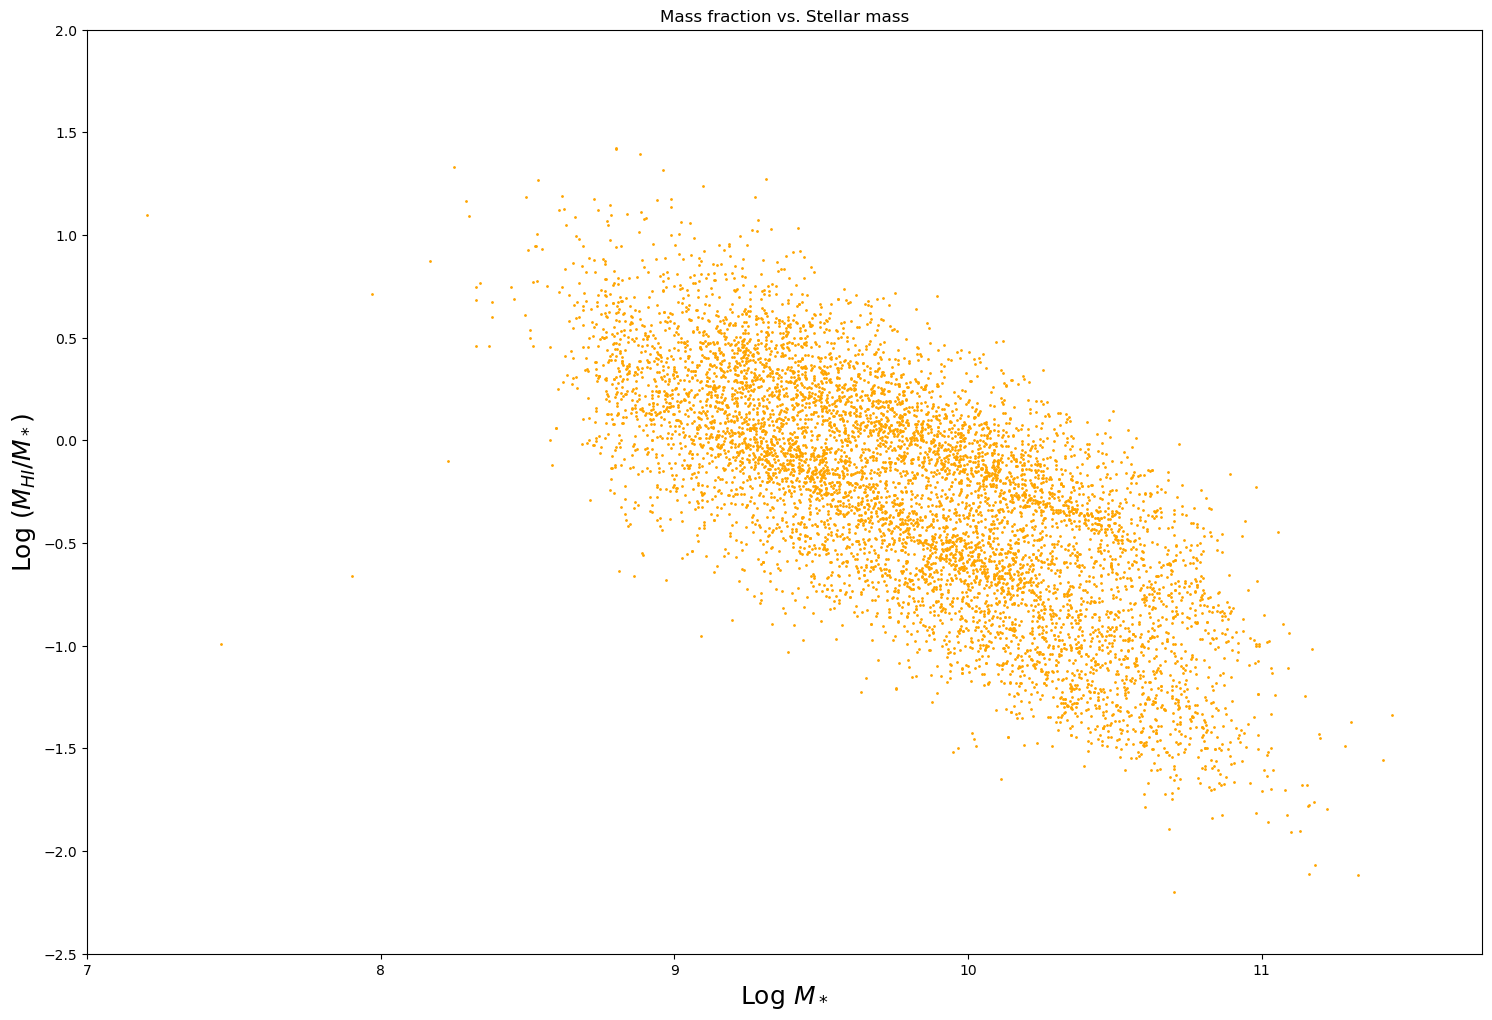

In [11]:
plt.figure(figsize=(18, 12))
plt.xlim(7, 11.75)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$', fontsize=18)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=18)
plt.title('Mass fraction vs. Stellar mass')
plt.scatter(allGalStellarMass, allGalMassFraction, s=1, color='orange');

Our data is becoming quite readable, and we have shown a general trend in galaxies that galaxies with greater stellar masses have lower mass fractions. What we want, however, is to compare the mass fractions of the well-aligned galaxies (that is, small differences in position angles between their discs) to the misaligned galaxies (larger differences in position angles). Therefore, lets make arrays for these more specific categories:

In [12]:
alignedMStars = []
alignedMFrac = []
MAMStars = [] #MA meaning 'misaligned'
MAMFrac =[]
for gal in dataTable:
    if gal['LOGMSTARS'] > 0 and max(gal['LOGMHI'], gal['LOGHILIM200KMS']) > 0 and str(gal['ang_stellar']) == 'nan':
        alignedMStars.append(gal['LOGMSTARS'])
        alignedMFrac.append(max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS'])
    if gal['LOGMSTARS'] > 0 and max(gal['LOGMHI'], gal['LOGHILIM200KMS']) > 0 and str(gal['ang_stellar']) != 'nan':
        MAMStars.append(gal['LOGMSTARS'])
        MAMFrac.append(max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS'])

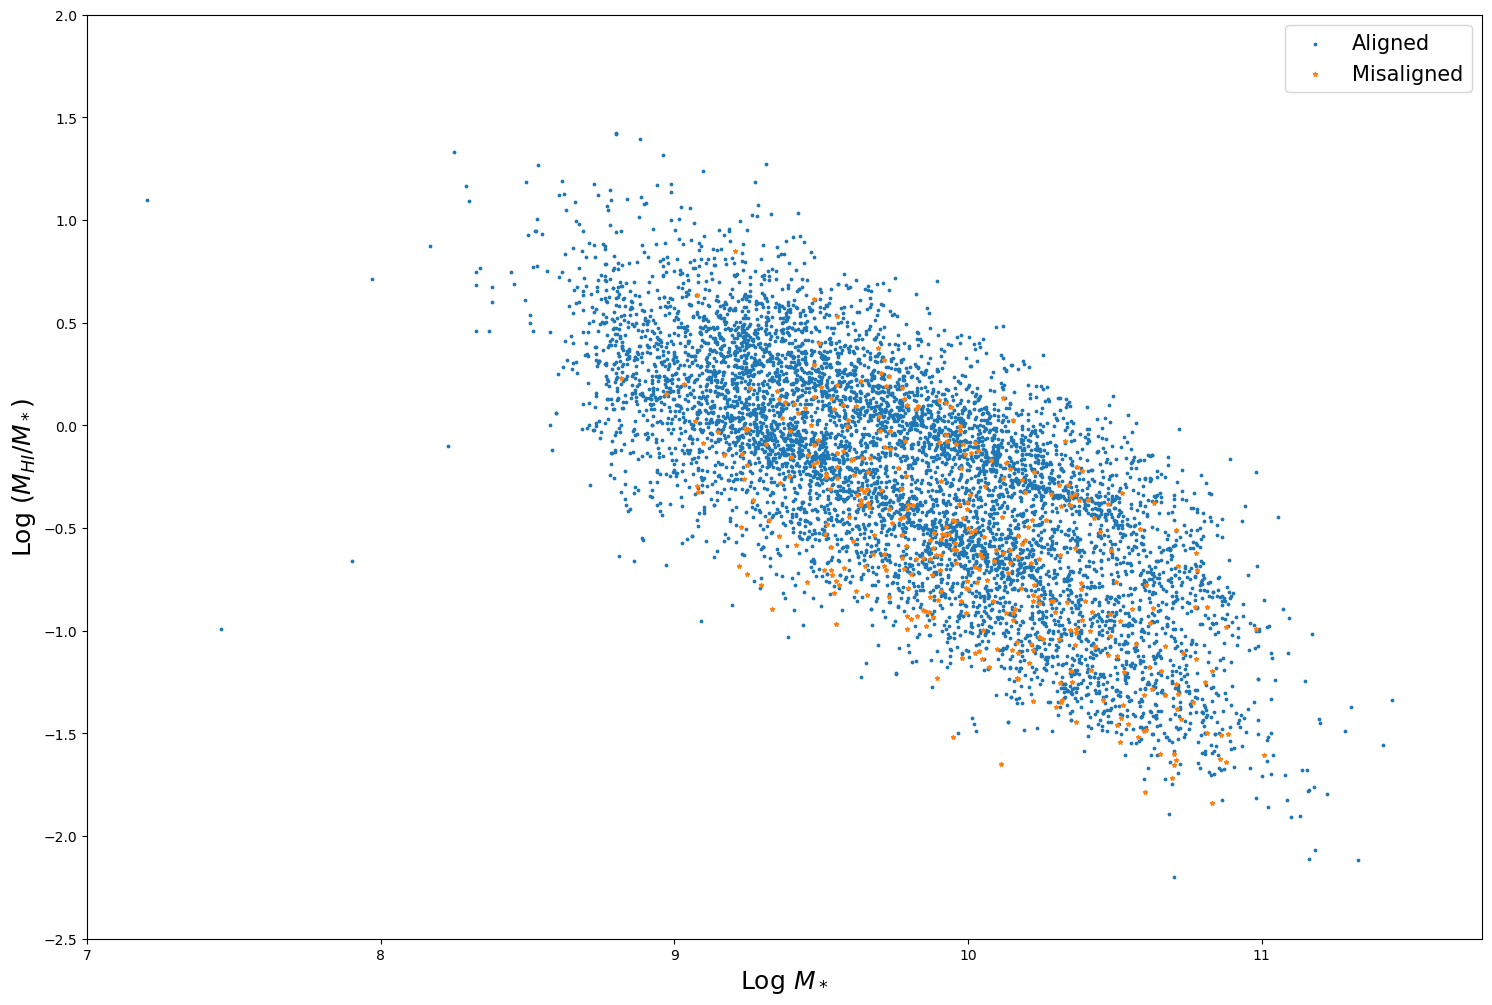

In [13]:
plt.figure(figsize=(18, 12))
plt.xlim(7, 11.75)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$', fontsize=18)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=18)
plt.scatter(alignedMStars, alignedMFrac, s=3, label = 'Aligned')
plt.scatter(MAMStars, MAMFrac, s=9, label = 'Misaligned', marker = '*');
plt.legend(fontsize = 15)
plt.show()

Great! We've picked out the points that correspond to misaligned galaxies from those corresponding to well-aligned galaxies. To make this analysis more qualitative, let's fit trends to each set of data.

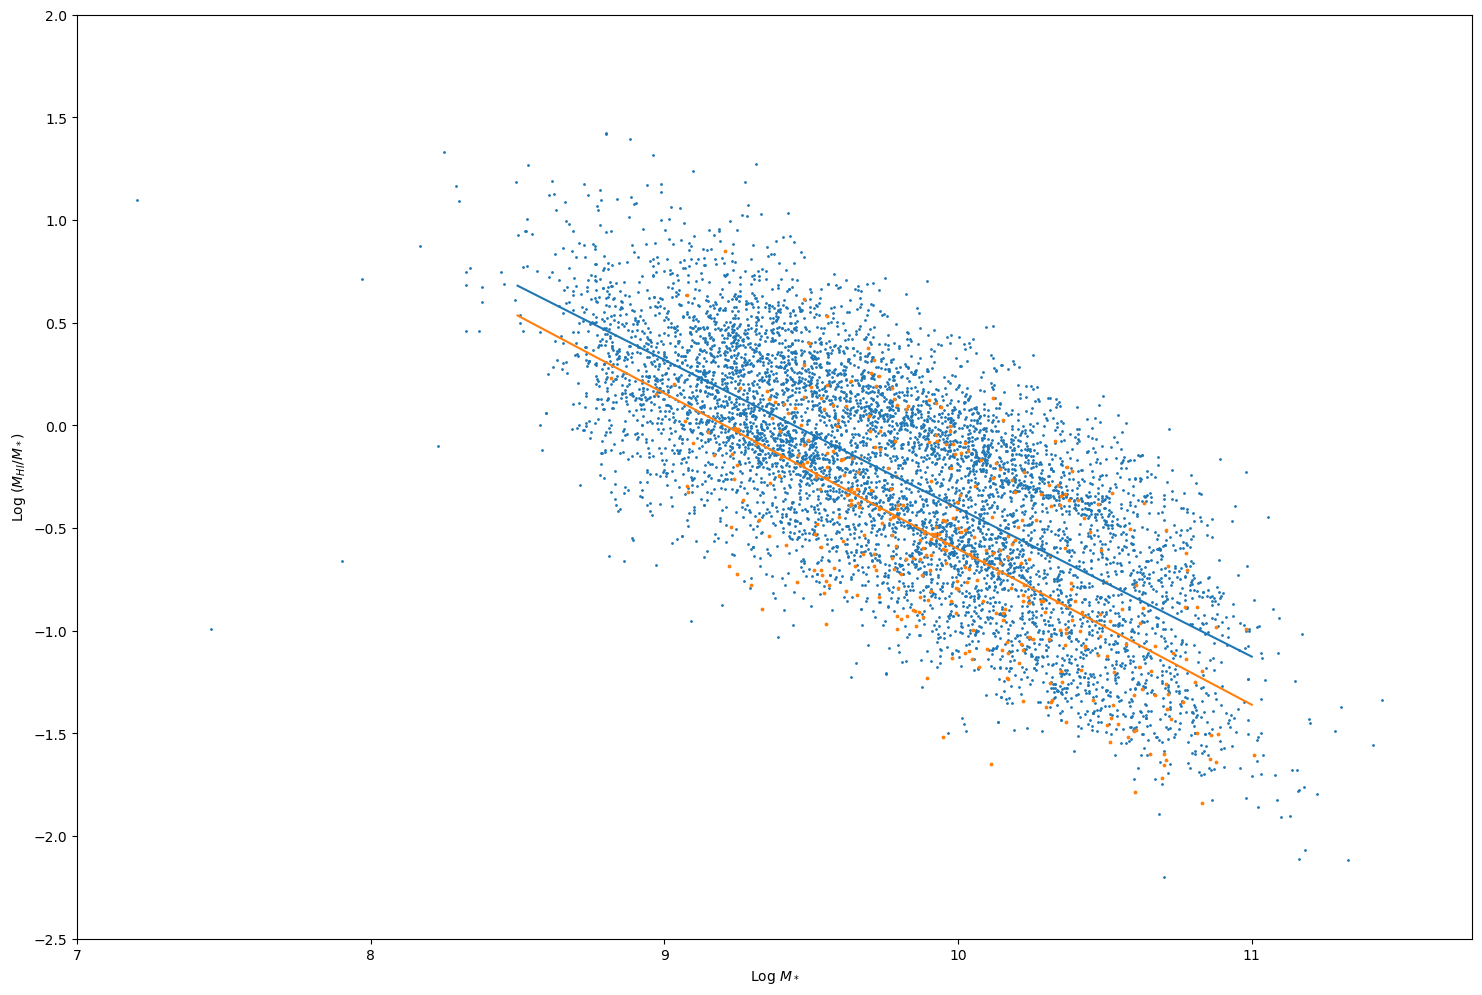

In [14]:
WAlinFit = np.polyfit(alignedMStars, alignedMFrac, 1)
MAlinFit = np.polyfit(MAMStars, MAMFrac, 1)
alignedAr = [[8.5, 11],[8.5*WAlinFit[0] + WAlinFit[1], 11*WAlinFit[0] + WAlinFit[1]]]
MAAr = [[8.5, 11],[8.5*MAlinFit[0] + MAlinFit[1], 11*MAlinFit[0] + MAlinFit[1]]]

plt.figure(figsize=(18, 12))
plt.xlim(7, 11.75)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$')
plt.ylabel('Log $(M_{HI}/M_*)$')
plt.scatter(alignedMStars, alignedMFrac, s=1)
plt.scatter(MAMStars, MAMFrac, s=3)
plt.plot(alignedAr[0], alignedAr[1])
plt.plot(MAAr[0], MAAr[1])
plt.show()

Interesting! It seems that misaligned galaxies actually have *less* gas than their well-aligned counterparts, which is not necessarily what we expect. Usually misalignment results from a recent accretion of new gas into the galaxy, gas which preserves its angular momentum therefore creating a misaligned gas disc. This suggests that the processes at play are more complicated than they appear, but we can make the trends more precise. Let's bin the data into segments. This binning code is modified from Patrick Wang (Haverford College '27).

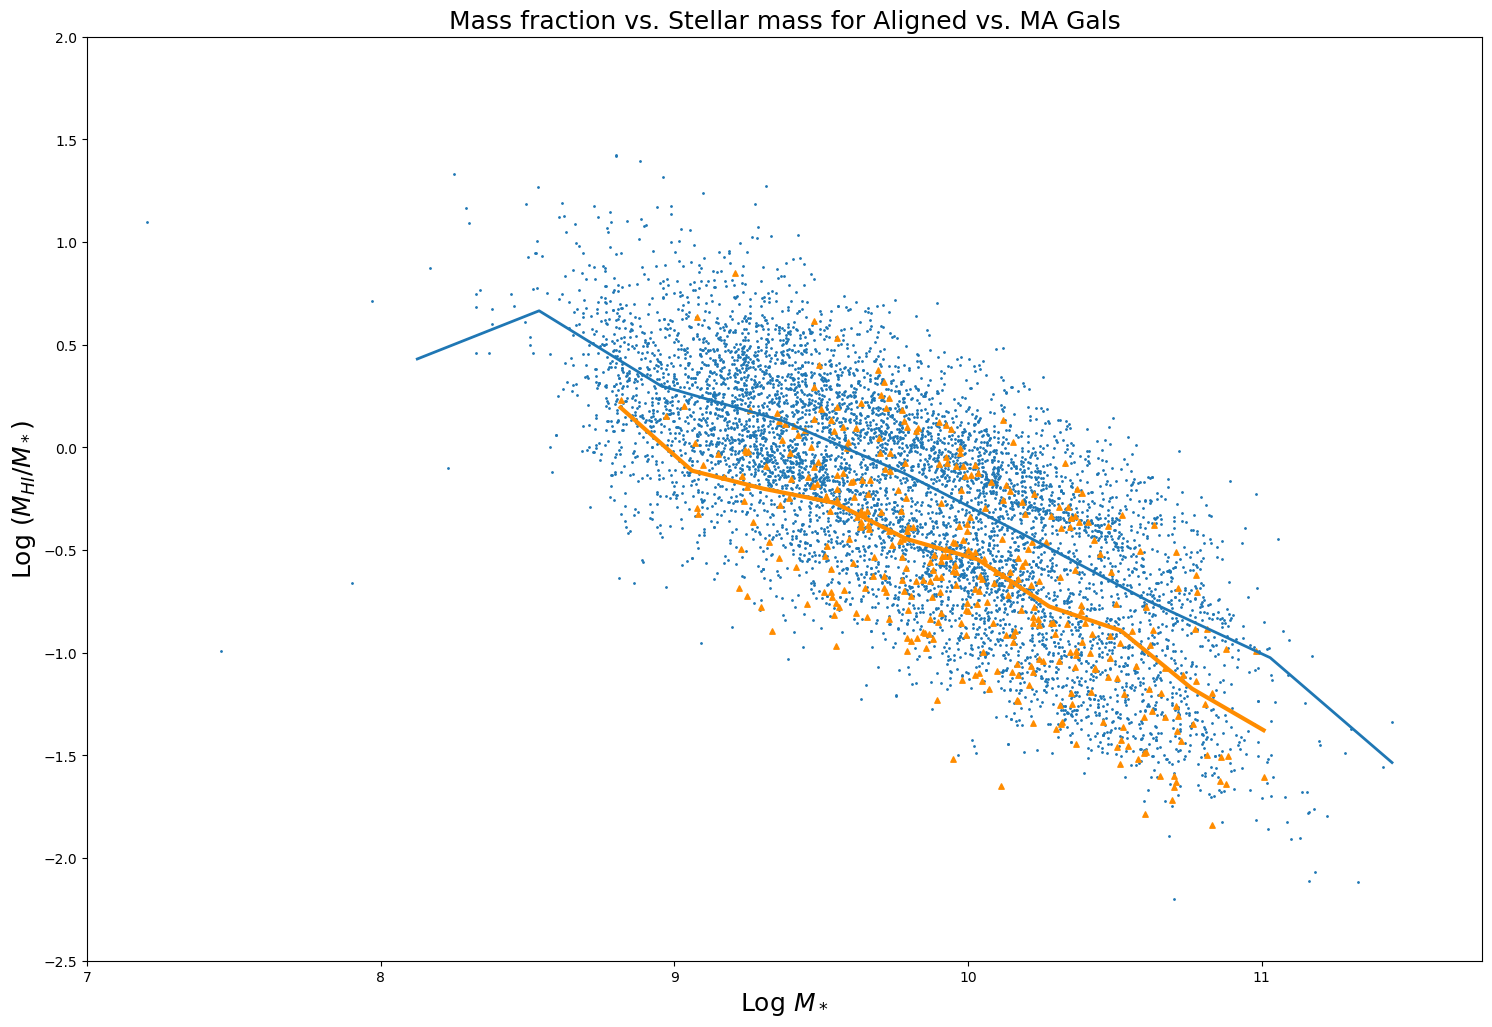

In [15]:
alignedBin = scipy.stats.binned_statistic(alignedMStars, alignedMFrac, 'mean', bins=20)
alignedXs = np.linspace(min(alignedMStars), max(alignedMStars), 20)

MABin = scipy.stats.binned_statistic(MAMStars, MAMFrac, 'mean', bins=10)
MAXs = np.linspace(min(MAMStars), max(MAMStars), 10)

plt.figure(figsize=(18, 12))
plt.xlim(7, 11.75)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$', fontsize=18)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=18)
plt.title('Mass fraction vs. Stellar mass for Aligned vs. MA Gals', fontsize=18)
plt.scatter(alignedMStars, alignedMFrac, s=1, color = 'tab:blue')
plt.scatter(MAMStars, MAMFrac, s=15, color = 'darkorange', marker='^')

plt.plot(alignedXs, alignedBin[0], lw=2, color = 'tab:blue')
plt.plot(MAXs, MABin[0], lw=3, color = 'darkorange')
plt.show()

We still haven't analyzed any of the upper limits with proper statistical methods, but by binning the data we can show a more robust difference between the two data sets than with a simple linear fit. We've confirmed that there is indeed a correlation between galaxies having position angle misalignment, and having a greater HI deficiency than an aligned galaxy with the same stellar mass.

The last thing we'll do with this data before statistically analyzing the upper limits with survival anlysis techniques is to divide the misaligned galaxies into various degrees of misalignment. Let's first make a plot of frequency vs misalignment in order to decide what cutoff of misalignment we will consider to be "counter-rotating"

In [16]:
misalignedHA = []
misalignedStel = []
for gal in dataTable:
    if str(gal['ang_ha']) != 'nan':
        if gal['ang_ha'] > 180:
            misalignedHA.append(360 - gal['ang_ha'])
        else:
            misalignedHA.append(gal['ang_ha'])
        if gal['ang_stellar'] > 180:
            misalignedStel.append(360 - gal['ang_stellar'])
        else:
            misalignedStel.append(gal['ang_stellar'])

misalignedDelPA = []
for i in range(len(misalignedHA)):
    misalignedDelPA.append(abs(misalignedHA[i] - misalignedStel[i]))

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
/var/folders/ny/khz4flkj0vd62fxcpk4skn1c0000gn/T/ipykernel_31165/2577010733.py:2: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$PA for misaligned galaxies')


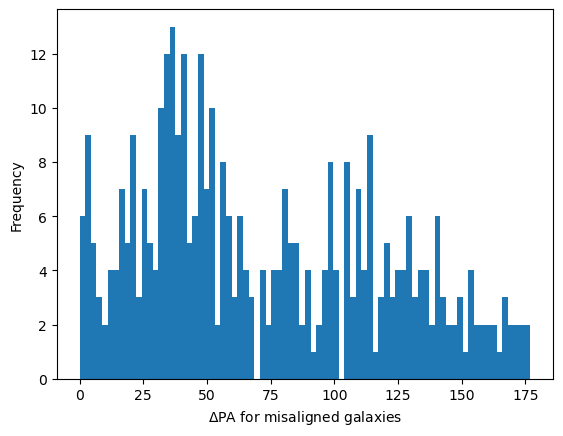

In [17]:
plt.figure()
plt.xlabel('$\Delta$PA for misaligned galaxies')
plt.ylabel('Frequency')
plt.hist(misalignedDelPA, bins=80);

There's no abundantly clear division. For now, let's just take all the galaxies with a misalignment of at least 90 degrees as 'counter-rotating,' and plot that data with binned averages.

In [18]:
counterMStel = []
counterFrac = []

for gal in dataTable:
    angHa = 0
    angStel = 0
    if str(gal['ang_ha']) != 'nan':
        if gal['ang_ha'] > 180:
            angHa = 360 - gal['ang_ha']
        else:
            angHa = gal['ang_ha']
        if gal['ang_stellar'] > 180:
            angStel = 360 - gal['ang_stellar']
        else:
            angStel = gal['ang_stellar']
    if abs(angHa - angStel) >= 90 and str(gal['LOGMSTARS']) != 'nan':
        counterMStel.append(gal['LOGMSTARS'])
        counterFrac.append(max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS'])

<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
/var/folders/ny/khz4flkj0vd62fxcpk4skn1c0000gn/T/ipykernel_31165/1499320159.py:11: SyntaxWarning: invalid escape sequence '\D'
  plt.scatter(counterMStel, counterFrac, s = 15, color = 'tab:red', marker = 'x', label = 'Misaligned galaxies ($\Delta$PA ≥ 90$\degree$)')


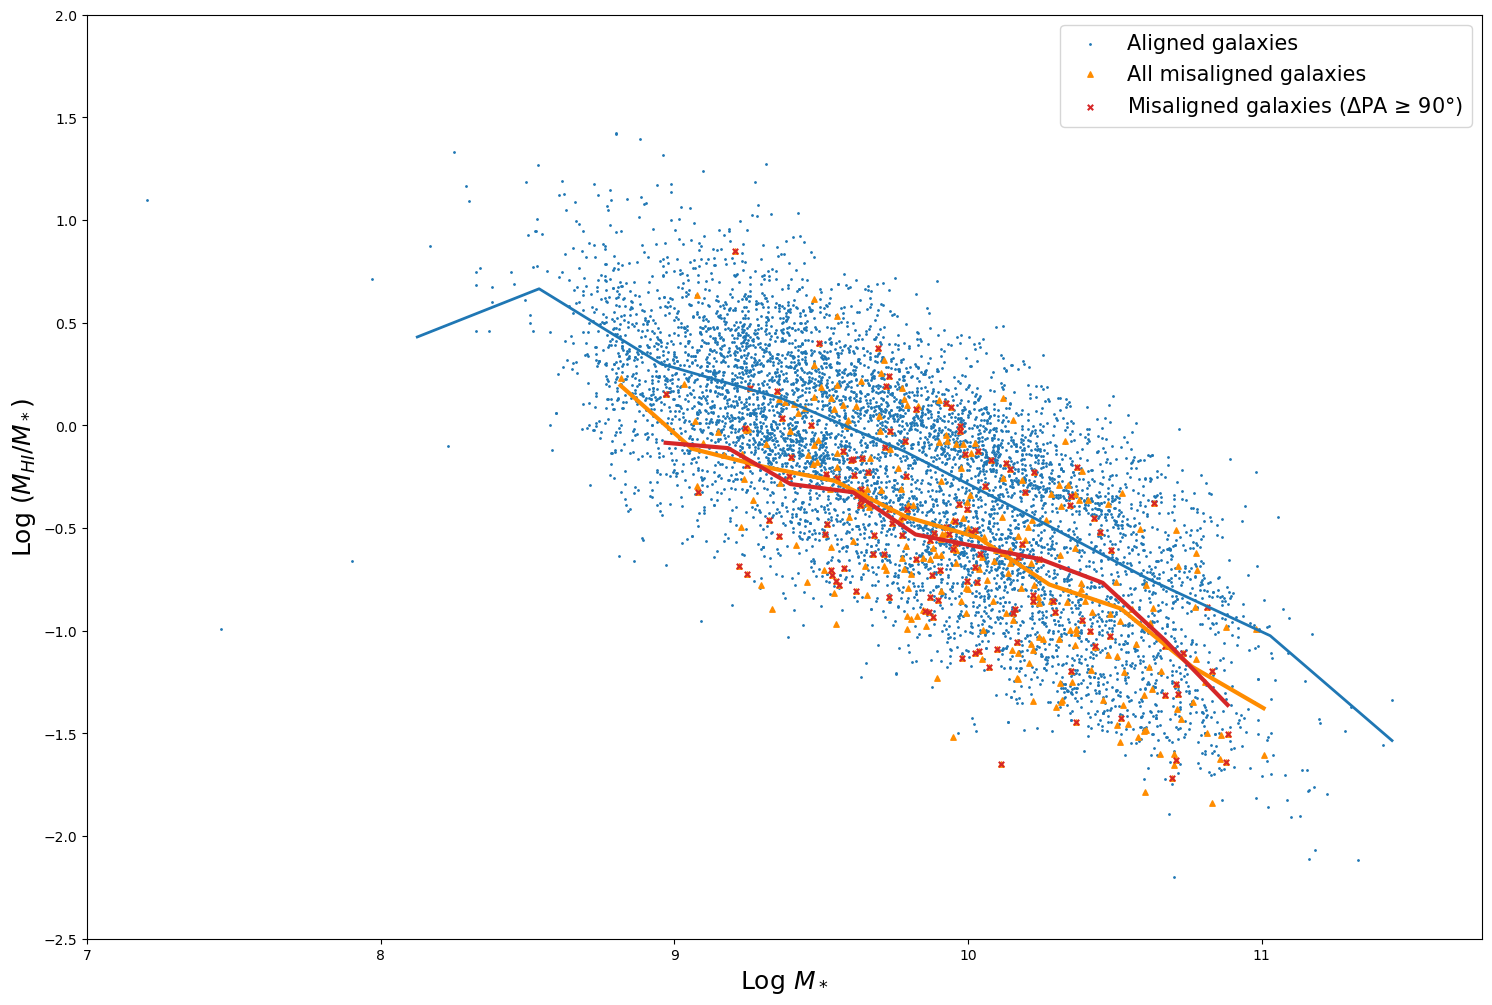

In [19]:
counterBin = scipy.stats.binned_statistic(counterMStel, counterFrac, 'mean', bins=10)
counterXs = np.linspace(min(counterMStel), max(counterMStel), 10)

plt.figure(figsize=(18, 12))
plt.xlim(7, 11.75)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$', fontsize=18)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=18)
plt.scatter(alignedMStars, alignedMFrac, s=1, color = 'tab:blue', label='Aligned galaxies')
plt.scatter(MAMStars, MAMFrac, s=15, color = 'darkorange', marker='^', label = 'All misaligned galaxies')
plt.scatter(counterMStel, counterFrac, s = 15, color = 'tab:red', marker = 'x', label = 'Misaligned galaxies ($\Delta$PA ≥ 90$\degree$)')

plt.plot(alignedXs, alignedBin[0], lw=2, color = 'tab:blue')
plt.plot(MAXs, MABin[0], lw=3, color = 'darkorange')
plt.plot(counterXs, counterBin[0], lw = 3, color='tab:red')
plt.legend(fontsize = 15)
# plt.savefig('mFrac_vs_mStel_binned.png')
plt.show()

Seeing that the counter-rotating galaxies (somewhat arbitrarily chosen to be those with ∆PA ≥ 90 degrees) display similar trends to the misaligned galaxies as a whole, which is noteworthy, I will choose to consider all misaligned galaxies for the remainder of this notebook for the larger sample size.

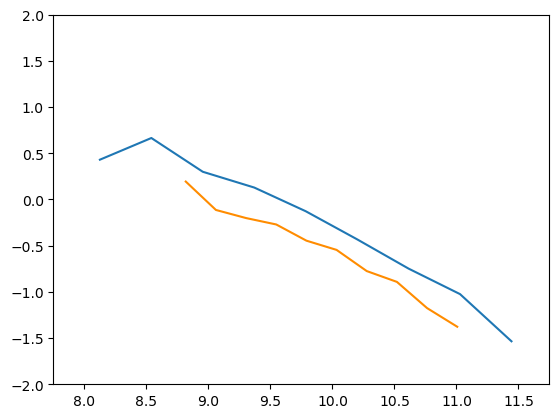

In [20]:
plt.xlim(7.75, 11.75)
plt.ylim(-2, 2)
plt.plot(alignedXs, alignedBin[0], color = 'tab:blue')
plt.plot(MAXs, MABin[0], color = 'darkorange');

Interestingly, we see that the group of all misaligned galaxies and the counter-rotating galaxies have very similar HI deficiencies, rather than the counter rotators having a more pronounced HI deficiency than other, less misaligned galaxies. However, we have still established a clear trend of misaligned galaxies having higher HI deficiencies than their well-aligned counterparts at their given stellar masses.

To quantify this deficiency, we can plot the difference between the HI deficiencies of the aligned galaxies and the HI deficiencies of the mis-aligned galaxies. Seeing that the counter-rotating galaxies have fairly similar trends to the mis-aligned galaxies as a whole, we will use the latter set, since it gives us more data points with which to work.

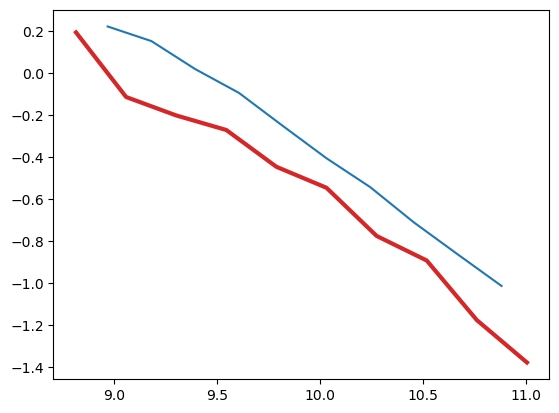

In [21]:
MABinDiff = [0]*10 # array of binned differences in HI deficiencies (on average, how deficient are each stellar mass's misaligned galaxies compared to that stellar mass's well-aligned galaxies)
limitedBin = []
limitedXs = []

for gal in dataTable:
    if max(counterXs) >= gal['LOGMSTARS'] >= min(counterXs) and str(gal['ang_ha']) == 'nan' and (gal['LOGMHI'] > 0 or gal['LOGHILIM200KMS'] > 0):
        limitedBin.append(max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS'])
        limitedXs.append(gal['LOGMSTARS'])

limitedAlignedBin = scipy.stats.binned_statistic(limitedXs, limitedBin, 'mean', bins=10)

plt.plot(np.linspace(min(limitedXs), max(limitedXs), 10), limitedAlignedBin[0], color = 'tab:blue')

for i in range(10):
    MABinDiff[i] =  limitedAlignedBin[0][i] - MABin[0][i]

#plt.plot(MAXs, MABinDiff);
plt.plot(MAXs, MABin[0], lw = 3, color='tab:red');

And we can normalize this plot, taking the difference between the two heights

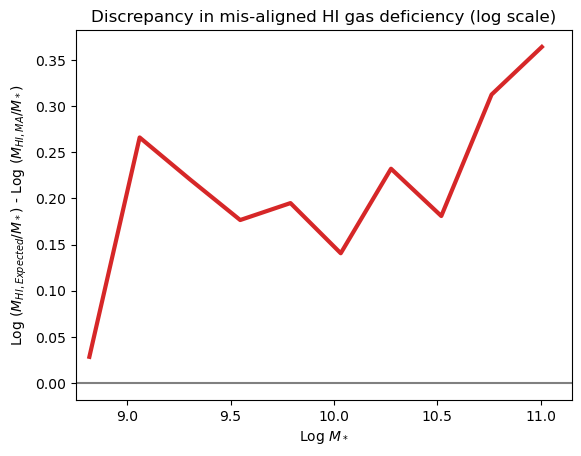

In [22]:
plt.xlim(8.75, 11.15)
plt.plot(MAXs, MABinDiff, lw = 3, color='tab:red')
plt.plot([5, 15], [0, 0], color = 'grey')
plt.title('Discrepancy in mis-aligned HI gas deficiency (log scale)')
plt.xlabel('Log $M_*$')
plt.ylabel('Log $(M_{HI, Expected}/M_*)$ - Log $(M_{HI, MA}/M_*)$')
plt.show()

We can convert this log scale to percentages to understand the significance of this data:

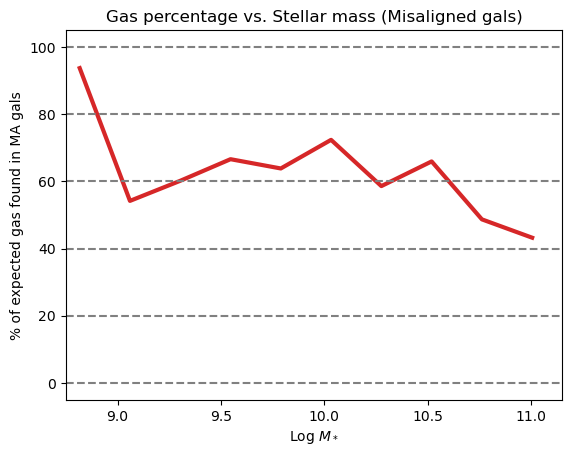

In [23]:
plt.xlim(8.75, 11.15)

MABinDiffPerc = [0]*10
for i in range(10):
    MABinDiffPerc[i] = 10**(-MABinDiff[i]) * 100

plt.xlabel('Log $M_*$')
plt.ylabel('% of expected gas found in MA gals')
plt.title('Gas percentage vs. Stellar mass (Misaligned gals)')
plt.plot(MAXs, MABinDiffPerc, lw = 3, color='tab:red')


plt.axhline(0, linestyle = '--', color = 'grey')
plt.axhline(20, linestyle = '--', color = 'grey')
plt.axhline(40, linestyle = '--', color = 'grey')
plt.axhline(60, linestyle = '--', color = 'grey')
plt.axhline(80, linestyle = '--', color = 'grey')
plt.axhline(100, linestyle = '--', color = 'grey')
plt.show()

From this plot, we can see that misaligned galaxies can have 60-70% of the HI gas as we expect from a well-aligned galaxy at their given stellar mass, which is an extremely large difference.

To take binned *medians*, with error bars, we will include upper limits as accepted values. The following code is again modified from Patrick Wang (HC '27)


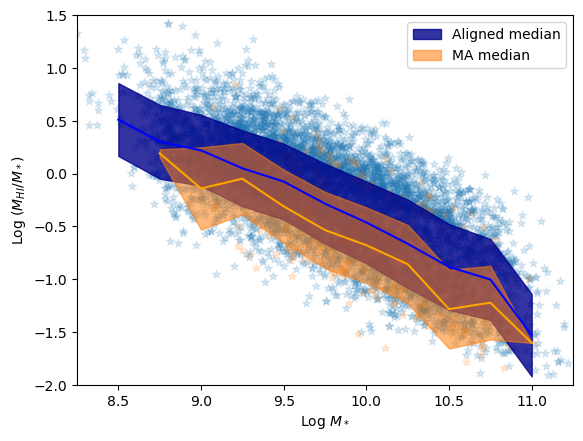

In [24]:
plt.xlim(8, 11.5)
plt.ylim(-2.5, 2)

Alignedmedians, Alignededgesmedian, Alignednummedian = scipy.stats.binned_statistic(alignedMStars,alignedMFrac,'median',bins=np.arange(8.5,11.5,0.25))
Alignedstds, Alignededgesstd, Alignednumstd=scipy.stats.binned_statistic(alignedMStars,alignedMFrac,'std',bins=np.arange(8.5,11.5,0.25))

MAmedians, MAedgesmedian, MAnummedian = scipy.stats.binned_statistic(MAMStars, MAMFrac, statistic = 'median', bins=np.arange(8.5,11.5,0.25))
MAstds,MAedgesstd,MAnumstd=scipy.stats.binned_statistic(MAMStars,MAMFrac, statistic = 'std', bins=np.arange(8.5,11.5,0.25))

plt.scatter(alignedMStars, alignedMFrac, marker = '*', color='tab:blue', alpha=0.15)
plt.scatter(MAMStars, MAMFrac, marker = '*', color='tab:orange', alpha=0.15)

#plotting binned data by using the edges of the bins
plt.plot(Alignededgesmedian[:-1], Alignedmedians, ls='-', alpha=1, color='blue')
plt.plot(MAedgesmedian[:-1], MAmedians, ls='-', alpha=1, color='orange')

#highlighting the standard deviation of this binned data
plt.fill_between(Alignededgesmedian[:-1],Alignedmedians-Alignedstds,Alignedmedians+Alignedstds,alpha=.8, color='darkblue', label='Aligned median')
plt.fill_between(MAedgesmedian[:-1],MAmedians-MAstds,MAmedians+MAstds,alpha=.55, color='tab:orange', label='MA median')
plt.legend()
plt.xlabel('Log $M_*$')
plt.ylabel('Log $(M_{HI}/M_*)$')
plt.ylim(-2, 1.5)
plt.xlim(8.25, 11.25)
plt.show()

In [25]:
medianMStel = []
medianMFracDiff = []
adjustedDiff = []

for i in range(10):
    if MAmedians[i] > -100:
        medianMStel.append(Alignededgesmedian[:-1][i])
        medianMFracDiff.append(Alignedmedians[i] - MAmedians[i])
        adjustedDiff.append(100 * 10**(-1 * (Alignedmedians[i] - MAmedians[i])))


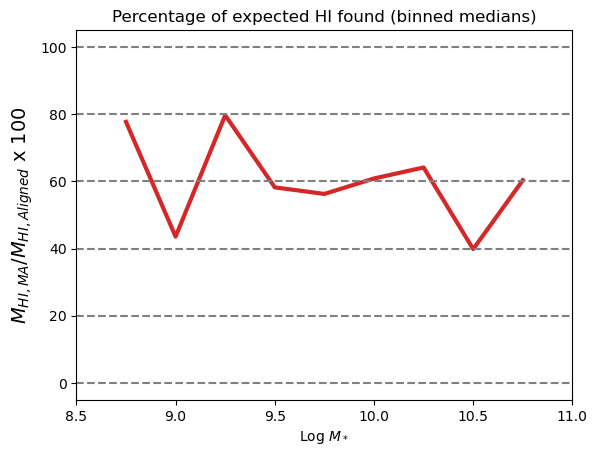

In [26]:
plt.plot(medianMStel, adjustedDiff, lw = 3, color='tab:red')
plt.axhline(0, linestyle = '--', color = 'grey')
plt.axhline(20, linestyle = '--', color = 'grey')
plt.axhline(40, linestyle = '--', color = 'grey')
plt.axhline(60, linestyle = '--', color = 'grey')
plt.axhline(80, linestyle = '--', color = 'grey')
plt.axhline(100, linestyle = '--', color = 'grey')
plt.xlim(8.5, 11)
plt.title('Percentage of expected HI found (binned medians)')
plt.xlabel('Log $M_*$')
plt.ylabel('$M_{HI, MA}/M_{HI, Aligned}$ x 100', fontsize=14);

**Survival Analysis:** In order to do survival analysis, we'll need to first create new data sets corresponding to the detections vs upper limis (non-detections). The detections will have entries in the 'LOGMHI' column of the fits image (other than 'NaN' or -999), while the non-detections will have entries in the 'LOGLIMHI200KMS' column (other than 'NaN' or -999). Also, we've just shown a distinct but fluctuating HI deficiency in misaligned galaxies with binned data, but for purposes of survival analysis, we'll be using a simple linear fit (at least for now).

In [27]:
WADetectionStel = []
WADetectionFrac = []
WALimStel = []
WALimFrac = []

MADetectionStel = []
MADetectionFrac = []
MALimStel = []
MALimFrac = []

for gal in dataTable:
    if gal['LOGMSTARS'] > 0 and gal['LOGMHI'] > 0: # Well-defined gas mass
        if str(gal['ang_ha']) != 'nan': # Misaligned, so has an entry from the misaligned galaxy fits file
            MADetectionStel.append(gal['LOGMSTARS'])
            MADetectionFrac.append(gal['LOGMHI'] - gal['LOGMSTARS'])
        elif str(gal['ang_ha']) == 'nan': # Aligned, so does not
            WADetectionStel.append(gal['LOGMSTARS'])
            WADetectionFrac.append(gal['LOGMHI'] - gal['LOGMSTARS'])
    elif gal['LOGMSTARS'] > 0 and gal['LOGHILIM200KMS'] > 0: # Upper limit/non-detection
        if str(gal['ang_ha']) != 'nan': # Misaligned, so has an entry from the misaligned galaxy fits file
            MALimStel.append(gal['LOGMSTARS'])
            MALimFrac.append(gal['LOGHILIM200KMS'] - gal['LOGMSTARS'])
        elif str(gal['ang_ha']) == 'nan': # Aligned, so does not
            WALimStel.append(gal['LOGMSTARS'])
            WALimFrac.append(gal['LOGHILIM200KMS'] - gal['LOGMSTARS'])

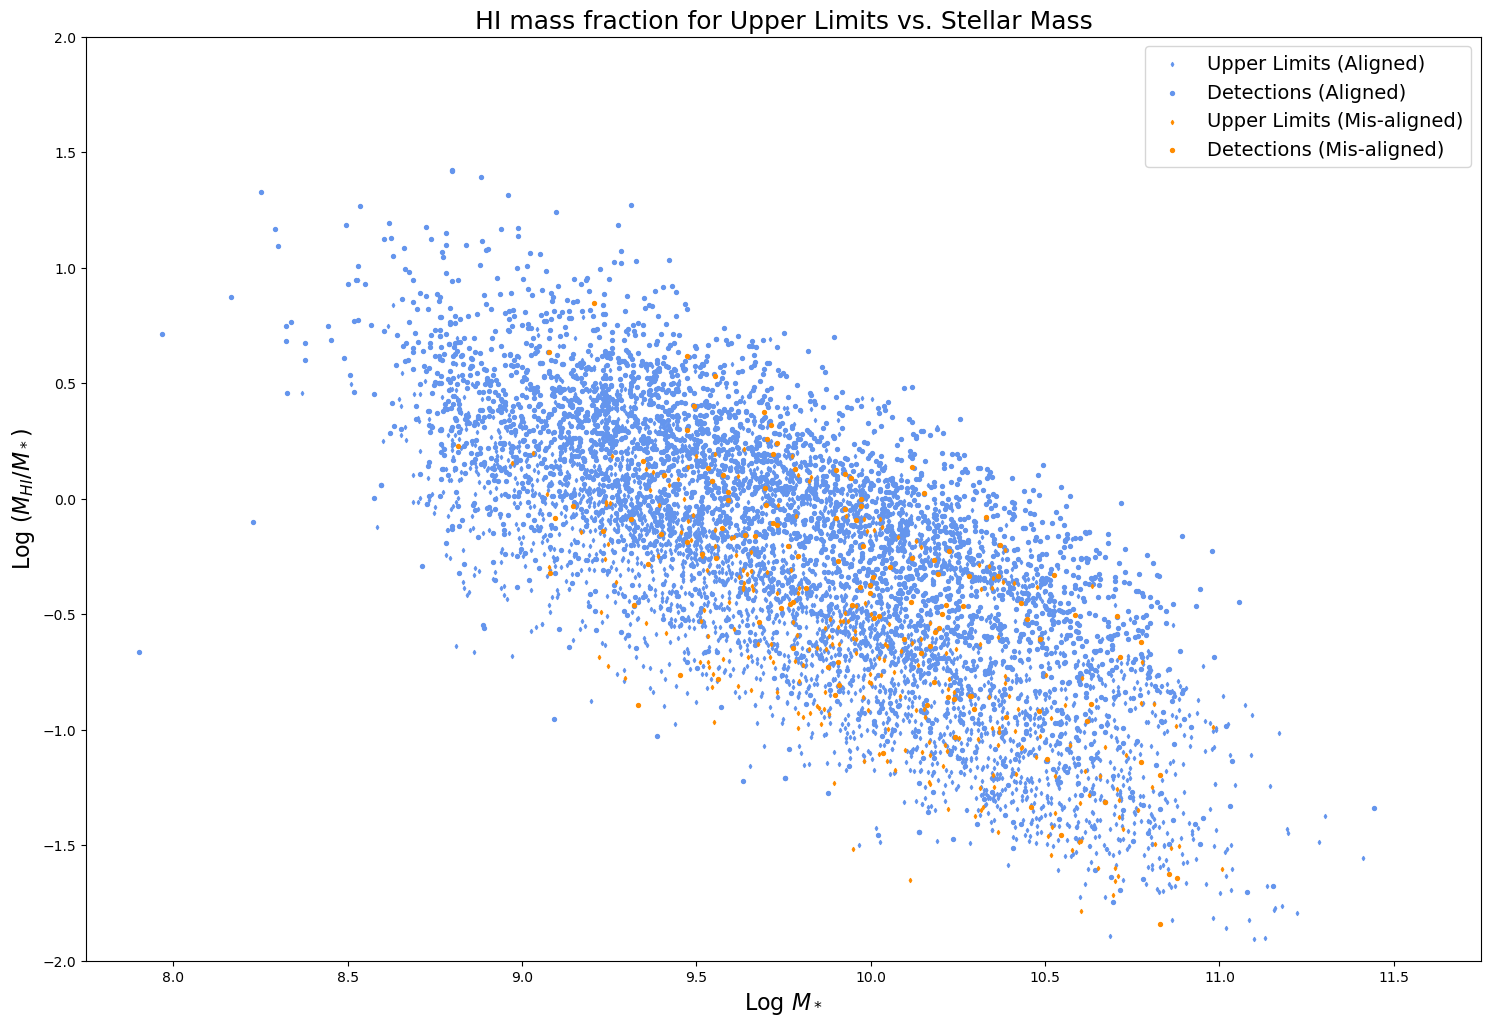

In [28]:
plt.figure(figsize=(18, 12))
plt.scatter(WALimStel, WALimFrac, label = 'Upper Limits (Aligned)', s=4, marker='d', color='cornflowerblue')
plt.scatter(WADetectionStel, WADetectionFrac, label = 'Detections (Aligned)', s=8, color='cornflowerblue')
plt.scatter(MALimStel, MALimFrac, label = 'Upper Limits (Mis-aligned)', s=4, marker='d', color='darkorange')
plt.scatter(MADetectionStel, MADetectionFrac, label = 'Detections (Mis-aligned)', s=8, color='darkorange')
plt.xlim(7.75, 11.75)
plt.ylim(-2, 2)
plt.legend(fontsize=14)
plt.xlabel('Log $M_*$', fontsize=16)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=16)
plt.title('HI mass fraction for Upper Limits vs. Stellar Mass', fontsize=18);
# plt.savefig('detectAndLim_with_alignedAndMA.png');

Using David Stark's survival analysis code, which wraps R statistical code for Python use, we can create a linear fits for the aligned galaxies (now performing statistical methods on this set which includes both detections and upper limits), and misaligned galaxies (similarly):

**Caution**: This cell takes 8 minutes to run, so if the data has not changed, refer to next cell

In [ ]:
# alignedComboMStars = np.ndarray(shape = len(alignedMStars)).astype(float)
# alignedComboMFrac = np.ndarray(shape = len(alignedMFrac)).astype(float)
# MAComboMStars = np.ndarray(shape = len(MAMStars)).astype(float)
# MAComboMFrac = np.ndarray(shape = len(MAMFrac)).astype(float)
#
# AlignedLims = np.ndarray(shape = len(alignedMStars)).astype(bool);
# MALims = np.ndarray(shape = len(MAMStars)).astype(bool);
#
# alignedGalInc = 0
# MAGalInc = 0
#
# alignedInc = 0
# MAInc = 0
#
# for gal in dataTable:
#     if gal['LOGMSTARS'] > 0 and max(gal['LOGMHI'], gal['LOGHILIM200KMS']) > 0 and str(gal['ang_ha']) == 'nan':
#         alignedComboMStars[alignedGalInc] = gal['LOGMSTARS']
#         alignedComboMFrac[alignedGalInc] = max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS']
#         if gal['LOGHILIM200KMS'] > 0: # If an upper limit
#             AlignedLims[alignedInc] = True
#         else:
#             AlignedLims[alignedInc] = False
#         alignedGalInc += 1
#         alignedInc += 1
#     if gal['LOGMSTARS'] > 0 and max(gal['LOGMHI'], gal['LOGHILIM200KMS']) > 0 and str(gal['ang_ha']) != 'nan':
#         MAComboMStars[MAGalInc] = gal['LOGMSTARS']
#         MAComboMFrac[MAGalInc] = max(gal['LOGMHI'], gal['LOGHILIM200KMS']) - gal['LOGMSTARS']
#         if gal['LOGHILIM200KMS'] > 0:
#             MALims[MAInc] = True
#         else:
#             MALims[MAInc] = False
#         MAGalInc += 1
#         MAInc += 1
#
# AlignedOut = ats_fit(alignedComboMStars, alignedComboMFrac, AlignedLims, fmt='(I4, 2F10.3)');
# MAOut = ats_fit(MAComboMStars, MAComboMFrac, MALims, fmt='(I4, 2F10.3)');
#
#
# np.save('Data/alignedComboMStars.npy', alignedComboMStars)
# np.save('Data/MAComboMStars.npy', MAComboMStars)
# np.save('Data/alignedComboMFrac.npy', alignedComboMFrac)
# np.save('Data/MAComboMFrac.npy', MAComboMFrac)
# np.save('Data/AlignedLims.npy', AlignedLims)
# np.save('Data/MALims.npy', MALims)
# np.save('Data/alignedOut.npy', AlignedOut)
# np.save('Data/MAOut.npy', MAOut)

In [30]:
alignedComboMStars = np.load('Data/alignedComboMStars.npy', allow_pickle=True)
MAComboMStars = np.load('Data/MAComboMStars.npy', allow_pickle=True)
alignedComboMFrac = np.load('Data/alignedComboMFrac.npy', allow_pickle=True)
MAComboMFrac = np.load('Data/MAComboMFrac.npy', allow_pickle=True)
AlignedOut = np.load('Data/alignedOut.npy', allow_pickle=True)
MAOut = np.load('Data/MAOut.npy', allow_pickle=True)
AlignedLims = np.load('Data/AlignedLims.npy', allow_pickle=True)
MALims = np.load('Data/MALims.npy', allow_pickle=True)

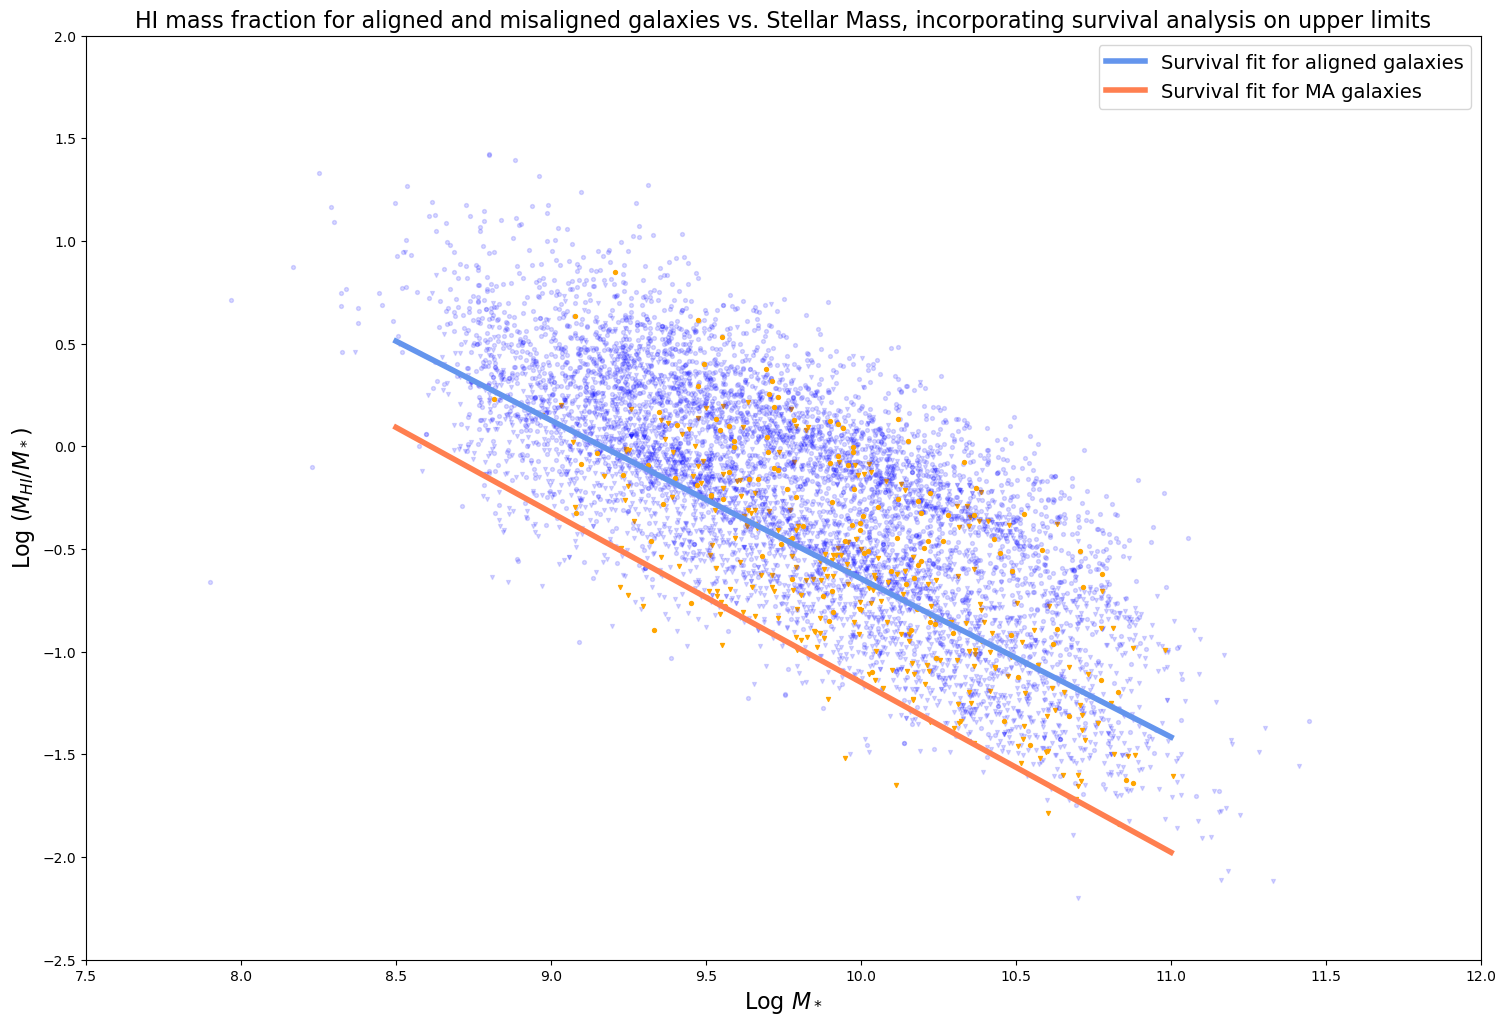

In [31]:
fig = plt.figure(figsize=(18, 12))

AlignedLimCol = 'blue'
AlignedDetCol = 'blue'
MALimCol = 'orange'
MADetCol = 'orange'

AlignedFitCol = 'cornflowerblue'
MAFitCol = 'coral'

# Upper limits:
plt.scatter(alignedComboMStars[AlignedLims], alignedComboMFrac[AlignedLims], s = 8, marker='v', color = AlignedLimCol, alpha = 0.15)
plt.scatter(MAComboMStars[MALims], MAComboMFrac[MALims], marker='v', s = 8, color = MALimCol)

# Detections:
plt.scatter(alignedComboMStars[~AlignedLims], alignedComboMFrac[~AlignedLims], s = 8, color = AlignedDetCol, alpha = 0.15)
plt.scatter(MAComboMStars[~MALims], MAComboMFrac[~MALims], s = 8, color = MADetCol)

pts = [8.5, 11]
plt.plot(pts, [(pts[0] * AlignedOut.item(0)['slope']) + AlignedOut.item(0)['intercept'], (pts[1] * AlignedOut.item(0)['slope']) + AlignedOut.item(0)['intercept']], color = AlignedFitCol, lw = 4, label = 'Survival fit for aligned galaxies')
plt.plot(pts, [(pts[0] * MAOut.item(0)['slope']) + MAOut.item(0)['intercept'], (pts[1] * MAOut.item(0)['slope']) + MAOut.item(0)['intercept']], color = MAFitCol, lw = 4, label = 'Survival fit for MA galaxies')

plt.legend(fontsize=14)
plt.xlim(7.5, 12)
plt.ylim(-2.5, 2)
plt.xlabel('Log $M_*$', fontsize=16)
plt.ylabel('Log $(M_{HI}/M_*)$', fontsize=16)
plt.title('HI mass fraction for aligned and misaligned galaxies vs. Stellar Mass, incorporating survival analysis on upper limits', fontsize=16);

In [32]:
print(10**(-1 * ((9.5 * AlignedOut.item(0)['slope'] + AlignedOut.item(0)['intercept']) - (9.5 * MAOut.item(0)['slope'] + MAOut.item(0)['intercept']))))

[0.33378503]


This data provides an even more shocking result, as by this method we conclude that the misaligned galaxies trend at only 33% of the expected HI mass expected at a given stellar mass (based on the difference between the values of the lines at $M_*$ = 9.5 $M_{Sun}$).

In [33]:
'''
# Upper limits:
plt.scatter(alignedComboMStars[AlignedLims], alignedComboMFrac[AlignedLims], s = 8, marker='v', color = AlignedLimCol, alpha = 0.15);
plt.scatter(MAComboMStars[MALims], MAComboMFrac[MALims], marker='v', s = 8, color = MALimCol);

# Detections:
plt.scatter(alignedComboMStars[~AlignedLims], alignedComboMFrac[~AlignedLims], s = 8, color = AlignedDetCol, alpha = 0.15);
plt.scatter(MAComboMStars[~MALims], MAComboMFrac[~MALims], s = 8, color = MADetCol);
'''
print('Aligned detection count: ', len(alignedComboMStars[~AlignedLims]))
print('Aligned upper limit count: ', len(alignedComboMStars[AlignedLims]))

print('\nMA detection count: ', len(MAComboMStars[~MALims]))
print('MA upper limit count: ', len(MAComboMStars[MALims]))

Aligned detection count:  3467
Aligned upper limit count:  3444

MA detection count:  119
MA upper limit count:  248


Unfortunately, we see that these sets are ≥ 50% non-detections, so this survival anlysis method will not necessarily provide us with reasonable or accurate results. Still, there are other statistical methods we can apply to this data to account for the presence of upper limits.

First, however, we can investigate if we can derive useful data for this survival analysis method for smaller selections of stellar mass. That is, if the upper limits skew towards higher stellar mass galaxies, then we can draw conclusions about the amount of expected HI found in misaligned galaxies within a more restricted (lower) stellar mass range.

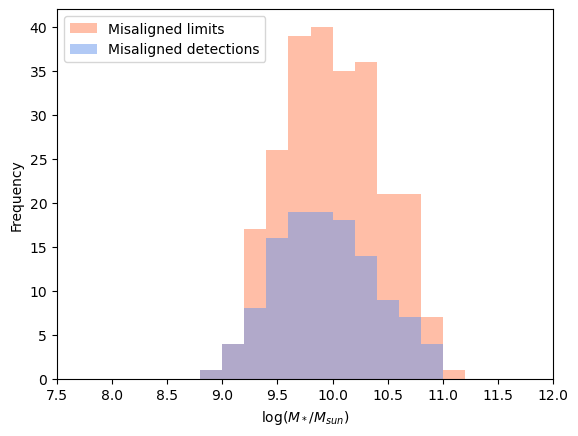

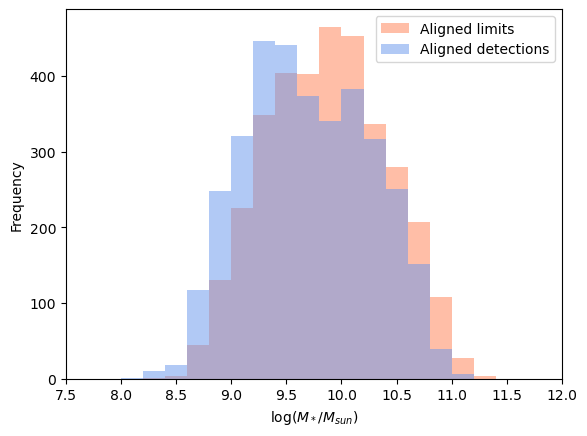

In [34]:
'''
Data:
Aligned upper limits: alignedComboMStars[AlignedLims]
Aligned detections: alignedComboMStars[~AlignedLims]

MA upper limits: MAComboMStars[MALims]
MA detections: MAComboMStars[~MALims]
'''

Bins = np.arange(8, 11.5, 0.2)

# Co-plotted histogram for frequency of misaligned gal detections vs. stellar mass and frequency of misaligned upper limits vs. stellar mass
plt.hist(MAComboMStars[MALims], alpha = 0.5, label = 'Misaligned limits', bins = Bins, color = 'coral')
plt.hist(MAComboMStars[~MALims], alpha = 0.5, label = 'Misaligned detections', bins = Bins, color = 'cornflowerblue')
plt.legend()
plt.xlim(7.5, 12)
plt.ylabel('Frequency')
plt.xlabel('log($M_*$/$M_{sun}$)')
plt.show()

# and co-plotted histogram for frequency of aligned detections vs. stellar mass and frequency of aligned upper limits vs stellar mass
plt.hist(alignedComboMStars[AlignedLims], alpha = 0.5, label = 'Aligned limits', bins = Bins, color = 'coral')
plt.hist(alignedComboMStars[~AlignedLims], alpha = 0.5, label = 'Aligned detections', bins = Bins, color = 'cornflowerblue')
plt.legend()
plt.xlim(7.5, 12)
plt.ylabel('Frequency')
plt.xlabel('log($M_*$/$M_{sun}$)')
plt.show()

Now to introduce the Kaplan-Meier test to produce cumulative distribution functions (CDFs) for the populations:

In [35]:
alignedKM = kaplan_meier(alignedComboMFrac, AlignedLims)
MAKM = kaplan_meier(MAComboMFrac, MALims)

     lim     gs
1      0  0.921
2      0 -0.083
3      0 -0.199
4      0 -0.386
5      0 -0.120
6      1 -0.194
7      1 -1.190
8      1 -0.462
9      1 -0.153
10     0 -1.474
11     0 -0.708
12     1 -1.177
13     0  0.579
14     0  0.365
15     1 -0.261
16     0  0.275
17     0 -0.061
18     0 -0.126
19     1 -0.949
20     0  0.044
21     0  0.503
22     0  0.282
23     0 -0.738
24     0  0.141
25     0 -0.558
26     0  0.177
27     0  0.662
28     0  0.397
29     1 -1.420
30     0  0.046
31     0  0.329
32     0 -0.207
33     0  0.080
34     0  0.448
35     0 -1.181
36     1 -0.963
37     0  0.286
38     0  0.314
39     1 -0.204
40     1 -0.503
41     0 -0.443
42     1 -0.542
43     1 -0.534
44     1 -0.640
45     1 -0.675
46     1 -1.104
47     1 -0.474
48     0  0.088
49     1  0.104
50     0  0.049
51     0  0.769
52     0  0.483
53     1 -0.414
54     1 -0.136
55     1 -0.625
56     1 -0.897
57     1 -0.222
58     1 -0.405
59     1 -2.197
60     0  0.562
61     0 -0.310
62     0

R callback write-console: 
Attaching package: ‘NADA’

  
R callback write-console: The following object is masked from ‘package:stats’:

    cor

  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  


    lim     gs
1     0 -0.125
2     1 -0.752
3     1 -0.893
4     1 -1.174
5     1 -1.649
6     1 -0.210
7     0 -0.266
8     1 -1.107
9     1 -0.689
10    1 -0.606
11    1 -0.204
12    1  0.195
13    1 -0.931
14    1  0.153
15    1 -1.117
16    0 -0.850
17    1 -1.517
18    1 -0.388
19    1 -0.983
20    1 -1.136
21    1 -0.858
22    1 -0.325
23    0 -0.669
24    1 -1.599
25    0 -0.497
26    1 -0.650
27    0  0.257
28    0 -0.533
29    1 -0.828
30    1 -0.312
31    1 -1.133
32    1 -0.029
33    0 -0.894
34    1 -0.719
35    1 -0.229
36    1 -0.392
37    1  0.199
38    1 -1.038
39    1 -0.778
40    1  0.186
41    0 -0.152
42    1 -0.759
43    1 -0.628
44    1 -1.444
45    1 -0.815
46    1 -0.706
47    1 -1.003
48    1 -0.706
49    1 -0.792
50    0 -0.296
51    1 -0.090
52    0 -0.728
53    1 -0.809
54    1 -0.607
55    0  0.103
56    1  0.086
57    1 -0.775
58    1 -0.628
59    0 -0.077
60    1 -1.066
61    1 -0.914
62    1 -0.195
63    1 -0.494
64    0 -0.083
65    0 -0.205
66    1  0

R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  


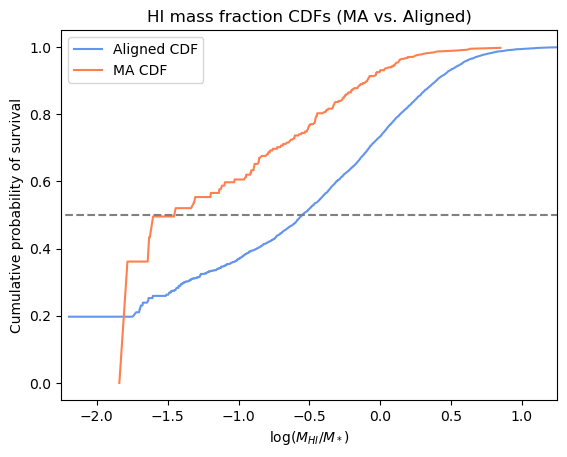

In [36]:
plt.plot(alignedKM['km']['x'], alignedKM['km']['surv'], label = 'Aligned CDF', color = 'cornflowerblue')
plt.plot(MAKM['km']['x'], MAKM['km']['surv'], label = 'MA CDF', color = 'coral')
plt.xlabel('log($M_{HI}$/$M_*$)')
plt.ylabel('Cumulative probability of survival')
plt.title('HI mass fraction CDFs (MA vs. Aligned)')
plt.plot([-3, 6], [0.5, 0.5], linestyle = '--', color = 'gray')
plt.xlim(-2.25, 1.25)
plt.legend()
plt.show()

I have implemented the Pipe3D data, which includes specific star formation rate data. This is to investigate if there is a significant correlation between star formation rate and HI deficiency.

In [37]:
WA_HIDepletion = []
MA_HIDepletion = []
HIDepletion_WA_masses = []
HIDepletion_MA_masses = []

for gal in dataTable:
    if gal['log_SFR_Ha'] > -600 and gal['LOGMSTARS'] > 0 and max(gal['LOGHILIM200KMS'], gal['LOGMHI']) > 0:
        if str(gal['ang_ha']) != 'nan': # Misaligned, so has an entry from the misaligned galaxy fits file
            MA_HIDepletion.append((max(gal['LOGHILIM200KMS'], gal['LOGMHI']) - gal['log_SFR_Ha']))
            HIDepletion_MA_masses.append(gal['LOGMSTARS'])
        elif str(gal['ang_ha']) == 'nan': # Aligned, so does not
            WA_HIDepletion.append((max(gal['LOGHILIM200KMS'], gal['LOGMHI']) - gal['log_SFR_Ha']))
            HIDepletion_WA_masses.append(gal['LOGMSTARS'])

WADepLims = np.ndarray(shape = len(WA_HIDepletion)).astype(bool);
MADepLims = np.ndarray(shape = len(MA_HIDepletion)).astype(bool);

MAcount = 0
WAcount = 0

for gal in dataTable:
    if gal['log_SFR_Ha'] > -999 and gal['LOGMSTARS'] > 0 and max(gal['LOGHILIM200KMS'], gal['LOGMHI']) > 0:
        if str(gal['ang_ha']) != 'nan': # Misaligned, so has an entry from the misaligned galaxy fits file
            if gal['LOGHILIM200KMS'] > 0: # If upper limit
                MADepLims[MAcount] = True
            elif gal['LOGMHI'] > 0: # Detection
                MADepLims[MAcount] = False
            MAcount += 1
        elif str(gal['ang_ha']) == 'nan': # Aligned, so does not
            if gal['LOGHILIM200KMS'] > 0: # If upper limit
                WADepLims[WAcount] = True
            elif gal['LOGMHI'] > 0: # Detection
                WADepLims[WAcount] = False
            WAcount += 1


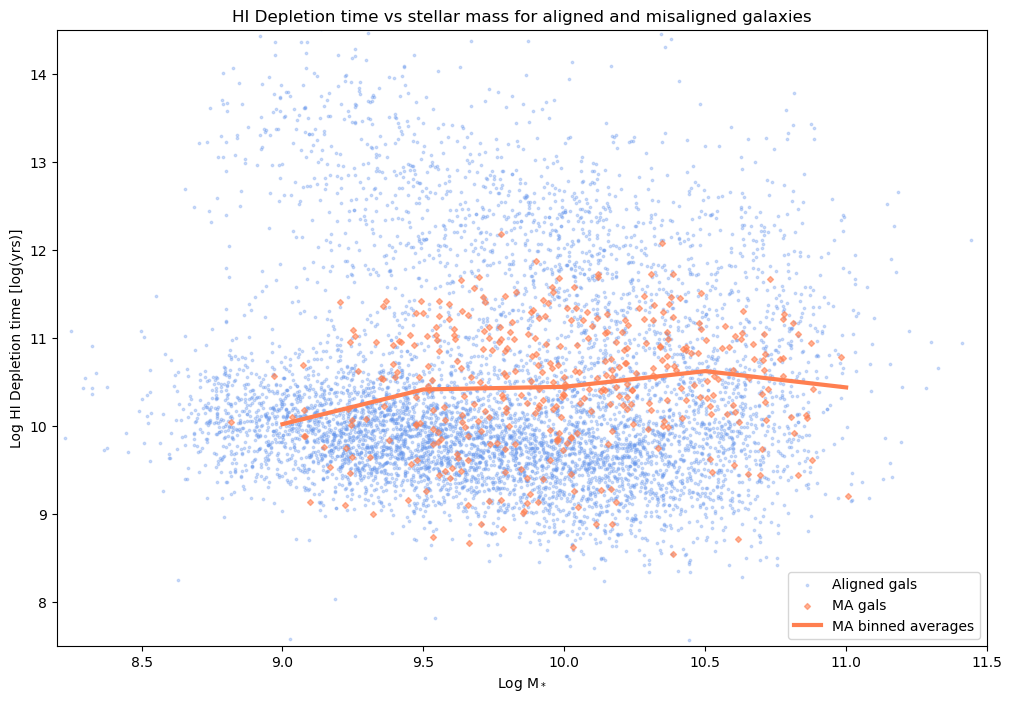

In [38]:
plt.figure(figsize = (12,8))
plt.scatter(HIDepletion_WA_masses, WA_HIDepletion, s = 3, color = 'cornflowerblue', label = 'Aligned gals', alpha = 0.3)
plt.scatter(HIDepletion_MA_masses, MA_HIDepletion, s = 9, marker = 'D', color = 'coral', label = 'MA gals', alpha = .6)

WA_SFR_bins = scipy.stats.binned_statistic(HIDepletion_WA_masses, WA_HIDepletion, 'mean', bins=[8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25])
MA_SFR_bins = scipy.stats.binned_statistic(HIDepletion_MA_masses, MA_HIDepletion, 'mean', bins=[8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25])

# plt.plot([8.5, 9, 9.5, 10, 10.5, 11], WA_SFR_bins[0], color = 'cornflowerblue', label = 'Aligned binned averages',
         # lw = 3)
plt.plot([8.5, 9, 9.5, 10, 10.5, 11], MA_SFR_bins[0], color = 'coral', label = 'MA binned averages',
         lw = 3)


plt.xlabel('Log M$_*$')
plt.ylabel('Log HI Depletion time [log(yrs)]')
plt.legend()
plt.title('HI Depletion time vs stellar mass for aligned and misaligned galaxies')
plt.xlim(8.2, 11.5)
plt.ylim(7.5, 14.5)
plt.show()

In [39]:
WADepKM = kaplan_meier(WA_HIDepletion, WADepLims)
MADepKM = kaplan_meier(MA_HIDepletion, MADepLims)

     lim     gs
1      0 10.440
2      0 10.192
3      0  9.675
4      0  9.705
5      0  9.382
6      1  9.837
7      1 11.573
8      1 12.464
9      1  9.514
10     0  9.784
11     0  9.348
12     1 11.266
13     0 10.113
14     0 10.157
15     1  9.991
16     0 10.271
17     0  9.758
18     0  9.539
19     1 10.605
20     0 10.039
21     0 10.554
22     0 10.306
23     0 10.729
24     0 10.512
25     0  9.846
26     0 10.336
27     0 10.386
28     0 10.438
29     1 13.390
30     0  9.657
31     0  9.824
32     0 10.352
33     0 10.028
34     0  9.811
35     0  8.815
36     1  9.421
37     0  9.255
38     0  9.933
39     1  9.897
40     1  9.865
41     0  9.974
42     1 11.672
43     1 11.781
44     1 12.780
45     1 12.756
46     1  9.194
47     1  9.091
48     0  9.713
49     1  9.003
50     0 10.246
51     0 10.541
52     1 13.119
53     1 13.702
54     1 12.846
55     1 12.152
56     1 13.077
57     1 12.499
58     1 12.017
59     0 10.378
60     0  9.396
61     0 10.041
62     0

R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  


    lim     gs
1     0 10.213
2     1 11.197
3     1 10.888
4     1 10.310
5     1  8.881
6     1 10.408
7     0 10.956
8     1  9.450
9     1  9.868
10    1 11.053
11    1 10.849
12    1 11.248
13    1 10.512
14    1 10.568
15    1 10.828
16    0 11.000
17    1  9.952
18    1 12.081
19    1 10.935
20    1  9.920
21    1 10.911
22    1 10.341
23    0 10.736
24    1  9.448
25    0 11.066
26    1 11.037
27    0  9.944
28    0 11.562
29    1  9.099
30    1  9.615
31    1  9.912
32    1 10.706
33    0 10.250
34    1 10.415
35    1 11.261
36    1 11.370
37    1 10.099
38    1 10.598
39    1 11.014
40    1 11.282
41    0 10.558
42    1 10.980
43    1 11.334
44    1 10.289
45    1 11.117
46    1  9.960
47    1 10.427
48    1 11.271
49    1  9.722
50    0 10.263
51    1 11.680
52    0  9.226
53    1 10.730
54    1 10.501
55    0 10.616
56    1  9.153
57    1 10.072
58    1 10.249
59    0  9.743
60    1 10.865
61    1 10.323
62    1  9.647
63    1  9.397
64    0 10.821
65    0 10.692
66    1 12

R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In regularize.values(x, y, ties, missing(ties), na.rm = na.rm) :  
R callback write-console: 
   
R callback write-console:  collapsing to unique 'x' values
  


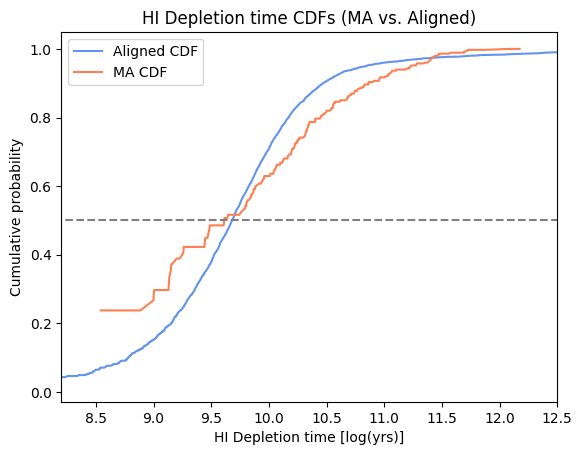

In [105]:
plt.plot(WADepKM['km']['x'], WADepKM['km']['surv'], label = 'Aligned CDF', color = 'cornflowerblue')
plt.plot(MADepKM['km']['x'], MADepKM['km']['surv'], label = 'MA CDF', color = 'coral')
plt.xlabel('HI Depletion time [log(yrs)]')
plt.ylabel('Cumulative probability')
plt.title('HI Depletion time CDFs (MA vs. Aligned)')
plt.hlines(0.5, 5, 15, color = 'gray', linestyle = '--')
plt.xlim(8.2, 12.5)
plt.legend()
plt.show()

In [38]:
WA_SFR = []
MA_SFR = []
SFR_WA_masses = []
SFR_MA_masses = []


for gal in dataTable:
    if str(gal['log_SFR_Ha']) != 'nan':
        if str(gal['ang_ha']) != 'nan': # Misaligned, so has an entry from the misaligned galaxy fits file
            MA_SFR.append(gal['log_SFR_Ha'] - gal['LOGMSTARS'])
            SFR_MA_masses.append(gal['LOGMSTARS'])
        elif str(gal['ang_ha']) == 'nan': # Aligned, so does not
            WA_SFR.append(gal['log_SFR_Ha'] - gal['LOGMSTARS'])
            SFR_WA_masses.append(gal['LOGMSTARS'])

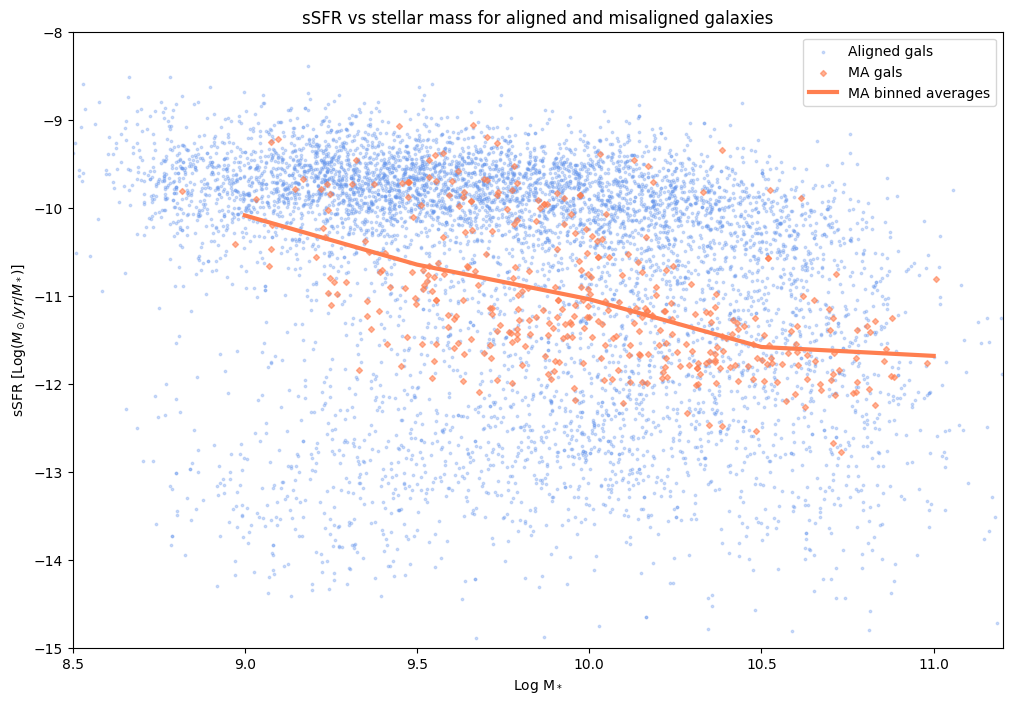

In [43]:
plt.figure(figsize = (12,8))
plt.scatter(SFR_WA_masses, WA_SFR, s = 3, color = 'cornflowerblue', label = 'Aligned gals', alpha = 0.3)
plt.scatter(SFR_MA_masses, MA_SFR, s = 9, marker = 'D', color = 'coral', label = 'MA gals', alpha = .6)

WA_SFR_bins = scipy.stats.binned_statistic(SFR_WA_masses, WA_SFR, 'mean', bins=[8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25])
MA_SFR_bins = scipy.stats.binned_statistic(SFR_MA_masses, MA_SFR, 'mean', bins=[8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25])

# plt.plot([8.5, 9, 9.5, 10, 10.5, 11], WA_SFR_bins[0], color = 'cornflowerblue', label = 'Aligned binned averages',
         # lw = 3)
plt.plot([8.5, 9, 9.5, 10, 10.5, 11], MA_SFR_bins[0], color = 'coral', label = 'MA binned averages',
         lw = 3)


plt.xlabel('Log M$_*$')
plt.ylabel('sSFR [Log($M_\odot/yr/M_*$)]')
plt.legend()
plt.title('sSFR vs stellar mass for aligned and misaligned galaxies')
plt.xlim(8.5, 11.2)
plt.ylim(-15, -8)
plt.show()